# **Ridge Regression sui prezzi delle automobili**

In questo notebook viene applicato l'algoritmo di *Ridge Regression* per effettuare una predizione su un dataset riguardo i prezzi di vendita di alcune automobili.

Vengono applicati diversi modelli, con gradi di polinomio e coefficienti differenti. Per poter determinare quale possa essere il modello migliore tra quelli presentati, vengono effettuate delle valutazioni su ogni modello generato.

## Dataset

Il dataset è reperibile su [Kaggle](https://www.kaggle.com/nehalbirla/vehicle-dataset-from-cardekho?select=car+data.csv). I dati presenti nel dataset fanno riferimento a [www.cardekho.com](https://www.cardekho.com).

Il dataset presenta i seguenti dati:

1. **Car_Name**: in questo campo viene inserito il nome dell'automobile
2. **Year**: l'anno in cui l'automobile è stata acquistata
3. **Selling_Price**: il prezzo con il quale il propetario vuole vendere l'automobile
4. **Present_Price**: l'attuale prezzo ex-showroom dell'automobile
5. **Kms_Driven**: chilometri percorsi
6. **Fuel_Type**: tipo di carburante dell'automobile
7. **Seller_Type**: indica se il venditore è un *commerciante* o un *individuo*
8. **Transmission**: indica la tipologia di trasmissione (*manuale* o *automatica*)
9. **Owner**: indica il numero di proprietari che l'automobile ha avuto in precedenza.

Di seguito è possibile vedere un esempio concreto del contenuto del dataset.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import io
from google.colab import files

uploaded = files.upload()

plt.style.use('seaborn-whitegrid')

# Load the dataset
dataset = pd.read_csv(io.BytesIO(uploaded['car data.csv']))

# Show the first few lines of the dataset
print(dataset.head())

Saving car data.csv to car data.csv
  Car_Name  Year  Selling_Price  ...  Seller_Type  Transmission Owner
0     ritz  2014           3.35  ...       Dealer        Manual     0
1      sx4  2013           4.75  ...       Dealer        Manual     0
2     ciaz  2017           7.25  ...       Dealer        Manual     0
3  wagon r  2011           2.85  ...       Dealer        Manual     0
4    swift  2014           4.60  ...       Dealer        Manual     0

[5 rows x 9 columns]


## Indice di correlazione di Pearson

Per poter trovare delle correlazioni tra le varie feature che offre il dataset, ho utilizzato l'**indice di correlazione di Pearson** (noto anche come **coefficiente di correlazione lineare**). Date due variabili statistiche, il coefficiente indica la presenza un'eventuale *relazione di linearità* tra di loro.

Il coefficiente è definito come la covarianza delle due variabili statistiche divisa per il prodotto delle deviazioni standard delle due variabili. L'indice assume sempre dei valori nell'intervallo -1 a +1. Sulla base di questa definizione, si possono distinguere principalmente tre casi (sia **P** l'indice di correlazione calcolato sulla base delle variabili *X* e *Y*):

1. P > 0: X e Y si dicono *direttamente correlate*;
2. P = 0: X e Y si dicono *incorrelate*;
3. P < 0: X e Y si dicono *inversamente correlate*.

Il codice seguente calcola la correlazione tra le varie feature e mostra i risulati in un grafico, in modo da notare più facilmente le correlazioni presenti.

                   Year  Selling_Price  Present_Price  Kms_Driven     Owner
Year           1.000000       0.236141      -0.047584   -0.524342 -0.182104
Selling_Price  0.236141       1.000000       0.878983    0.029187 -0.088344
Present_Price -0.047584       0.878983       1.000000    0.203647  0.008057
Kms_Driven    -0.524342       0.029187       0.203647    1.000000  0.089216
Owner         -0.182104      -0.088344       0.008057    0.089216  1.000000


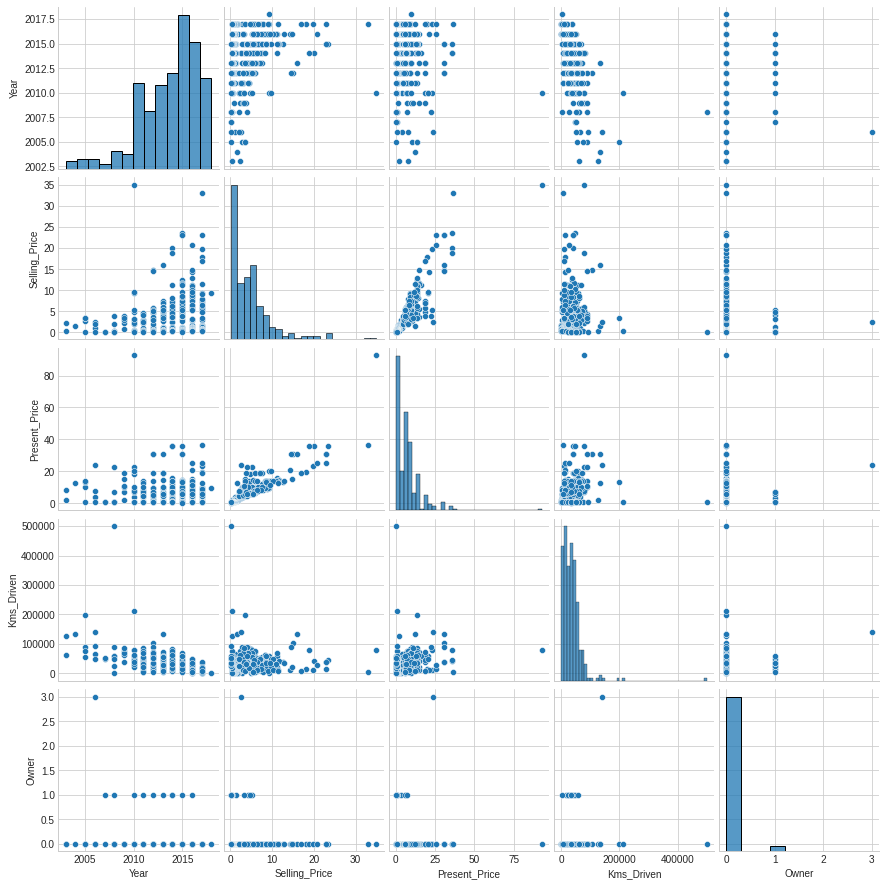

In [2]:
# Find correlations using Pearson correlation index
correlations = dataset.corr(method='pearson')
print(correlations)

# Plot the correlations in a chart
pairPlot = sns.pairplot(dataset, height=2.5)
plt.show()

É possibile notare che tra le feature `Present_Price` e `Seller_Price` vi è una correlazioni pari a 0.878983.

Pertanto, per la realizzazione di questo notebook, verranno prese in considerazioni tali feature.

Il codice seguente estrapola le feature dal dataset e illustra la loro correlazione.

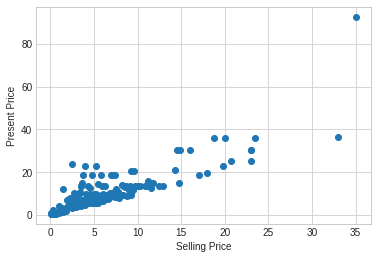

In [3]:
# Setup X and Y
selling_price = list(dataset["Selling_Price"])
present_price = list(dataset["Present_Price"])

# Create a custom DataFrame
data = dataset[["Selling_Price", "Present_Price"]]

# Show the correlation between Selling_Price and Present_Price
plt.xlabel('Selling Price')
plt.ylabel('Present Price')
plt.scatter(selling_price, present_price)
plt.show()

## Ridge Regression

Questa è la fase di applicazione della Ridge Regression.

Inizialmente, i dati estrapolati vengono suddivisi in dati di *train* e dati di *test*. Per essere più precisi, l'80% dei dati viene dedicato al set di train, mentre il 20% viene dedicato per effettuare i test sui vari modelli.

Vengono inoltre impostati alcuni parametri necessari per la realizzazione dei vari modelli:

1. `degrees`: in questo array vengono memorizzati tutti i gradi di polinomio che si vorranno utilizzare per la realizzazione dei modelli
2. `alphas`: sono dei coefficienti che verranno applicati a differenti modelli di Ridge Regression.

Nella Ridge Regression è presente un **termine di regolarizzazione** $\alpha$, il quale permette di migliorare il condizionamento del problema. Questo iperparametro permette di evitare che il polinomio generato vada a descrivere *troppo bene* i dati di train. Se così fosse, nel momento in cui venissero introdotti i dati test, il modello non riuscirebbe a predirre i valori forniti.

Pertanto, questo iperparametro cerca di portare verso lo zero le stime dei coefficienti, migliorando così l'addattamento del modello ai dati di train.

In [4]:
# Divide the dataset in train set and test set
x_train, x_test, y_train, y_test = train_test_split(data[["Selling_Price"]], data[["Present_Price"]], test_size=0.2, random_state=123)

# Setup degrees and alphas
degrees = [1, 2, 3, 4]
alphas = [[0, 5000, 10000], [0, 5000, 1000000], [0, 5000, 1000000], [0, 50000, 1000000]]

models = []
save_models_per_degree = []

mean_squared_errors = []
r_squares = []
best_models = []

legend = []
colors = ['orange', 'black', 'red']

In questa porzione di codice vengono generati diversi modelli con gradi di polinomio e coefficienti di regolarizzazione $\alpha$ differenti, a cui vengono forniti i dati di test da predirre.

Il primo modello che viene generato ha un polinomio di grado 1 e un coefficiente di regolarizzazione $\alpha$ pari a 0. Questo modello è anche detto **Linear Regression**, un caso speciale appunto della Ridge Regression.

I modelli successivi utilizzano una funzione con un grado maggiore.

Tutti i modelli di un determinato grado del polinomio vengono visualizzati nel rispettivo grafico.

Degree = 1
Alpha = 0
R^2 for train set: 0.7927689587917259
R^2 for test set: 0.552682105880517
MSE: 14.954751509774882

Alpha = 5000
R^2 for train set: 0.6459474550658479
R^2 for test set: 0.6433460438055851
MSE: 11.923670749556322

Alpha = 10000
R^2 for train set: 0.5057139071461532
R^2 for test set: 0.539708843974539
MSE: 15.388474172395009



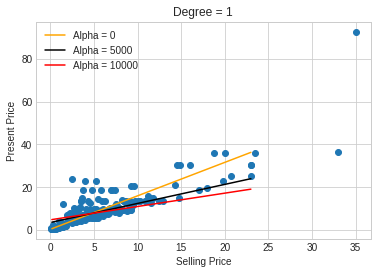

Degree = 2
Alpha = 0
R^2 for train set: 0.8056201924637213
R^2 for test set: 0.5440763242732622
MSE: 15.24246037896112

Alpha = 5000
R^2 for train set: 0.7519546803248245
R^2 for test set: 0.47646204214053456
MSE: 17.50294403297892

Alpha = 1000000
R^2 for train set: 0.6943298479270332
R^2 for test set: 0.45688499106489344
MSE: 18.157444865561715



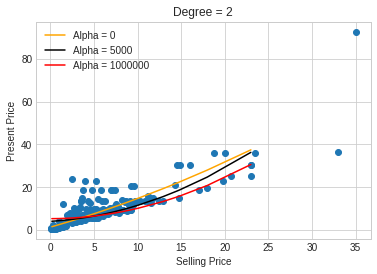

Degree = 3
Alpha = 0
R^2 for train set: 0.8237648084826832
R^2 for test set: 0.6660845761734626
MSE: 11.163475135365777

Alpha = 5000
R^2 for train set: 0.760803599719386
R^2 for test set: 0.4221433283813467
MSE: 19.318929660377638

Alpha = 1000000
R^2 for train set: 0.6596290225796826
R^2 for test set: 0.4038350555804948
MSE: 19.931012641875306



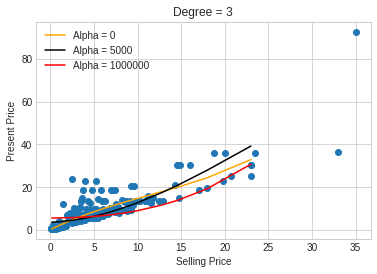

Degree = 4
Alpha = 0
R^2 for train set: 0.826613206588933
R^2 for test set: 0.6475371736572011
MSE: 11.783552712026225

Alpha = 50000
R^2 for train set: 0.771567783862537
R^2 for test set: 0.49167437036094397
MSE: 16.994364806857924

Alpha = 1000000
R^2 for train set: 0.6825106569043733
R^2 for test set: 0.3231956431063294
MSE: 22.626953026328753



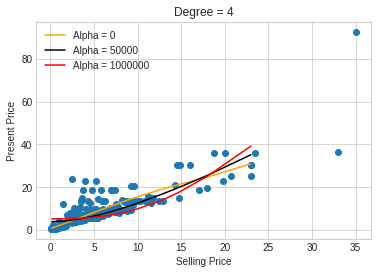

In [5]:
for degree in degrees:
    mean_squared_errors.clear()
    save_models_per_degree.clear()
    legend.clear()
    i = 0
    print('Degree = {}'.format(degree))

    for alpha in alphas[degree - 1]:
        ridge = make_pipeline(PolynomialFeatures(degree), linear_model.Ridge(alpha=alpha))
        ridge.fit(x_train, y_train)
        prediction = ridge.predict(x_test)

        # Determine R^2 for train set and test set
        r_square_train = ridge.score(x_train, y_train)
        r_square_test = ridge.score(x_test, y_test)
        r_squares.append(r_square_test)

        # Determine MSE
        mse = mean_squared_error(y_test, prediction)
        mean_squared_errors.append(mse)

        # Save the details of the model just generated
        save_models_per_degree.append([alpha, r_square_train, r_square_test, mse])

        print('Alpha = {}'.format(alpha))
        print('R^2 for train set: {}'.format(r_square_train))
        print('R^2 for test set: {}'.format(r_square_test))
        print('MSE: {}\n'.format(mse))

        # Prepare the data to plot
        data_test, test_prediction_data = zip(*sorted(zip(x_test["Selling_Price"], prediction), key=lambda x_0: x_0[0]))

        # Plot the results
        plt.plot(data_test, test_prediction_data, c=colors[i])
        legend.append('Alpha = {}'.format(alpha))

        i = i + 1

    models.append([m for m in save_models_per_degree])

    # Determine the best model based on R^2
    j = np.argmax(r_squares)
    best_models.append(r_squares[j])

    # Plot the dataset
    plt.title('Degree = {}'.format(degree))
    plt.xlabel('Selling Price')
    plt.ylabel('Present Price')
    plt.scatter(selling_price, present_price)
    plt.legend(legend)
    plt.show()

É possibile notare che all'aumento dell'iperparametro $\alpha$, il polinomio tende a generalizzare e a non modellare perfettamente i dati di train. Questo effetto si nota di più all'aumentare del grado del polinomio. Inoltre, per poter apprezzare la differenza tra differenti modelli del medesimo polinomio, bisogna incrementare significativamente l'iperparametro $\alpha$.

## Analisi dei modelli realizzati

Per determinare quale sia il modello che predice meglio i dati di test ho utilizzato il **coefficiente di determinazione** **R$^2$**. Questo indice permette di vedere quanto il modello è stato in grado di descrivere correttamente i dati di test forniti. R$^2$ fornisce sempre un valore compreso tra 0 e 1.

In Python, l'indice R$^2$ viene calcolato dal metodo `score`.

Tra tutti i modelli creati, vado a prendere il modello che ha un indice di R$^2$ maggiore a tutti gli altri.

In [6]:
# Find the best model index based on R^2
m = np.argmax(best_models)

print('Best model based on R^2')
for i, degree in enumerate(models, start=1):
    for element in degree:
        if best_models[m] == element[2]:
            print('Degree = {}\nAlpha = {}\nR^2 train = {}\nR^2 test = {}\nMSE = {}'.format(i, element[0], element[1], element[2], element[3]))

Best model based on R^2
Degree = 3
Alpha = 0
R^2 train = 0.8237648084826832
R^2 test = 0.6660845761734626
MSE = 11.163475135365777


In base al coefficiente R$^2$, il modello che descrive meglio i dati di test è il modello che ha un grado pari a 3 con un coefficiente di regolarizzazione $\alpha$ pari a 0 e con un valore di R$^2$ = 0.6660845761734626.

Di seguito vengono presentati una serie di grafici. I grafici della prima riga illustrano i coefficienti R$^2$ sia per i dati di train che per i dati di test, al variare sia del grado del polinomio che dell'iperparametro $\alpha$. Mentre, la seconda riga di grafici illustrano i **Mean Square Error** dei vari modelli al variare di $\alpha$. Il MSE è stato calcolato soltanto sui dati di test.

Il *Mean Square Error* indica il divario medio fra i valori dei dati di osservati ed i valori dei dati predetti.

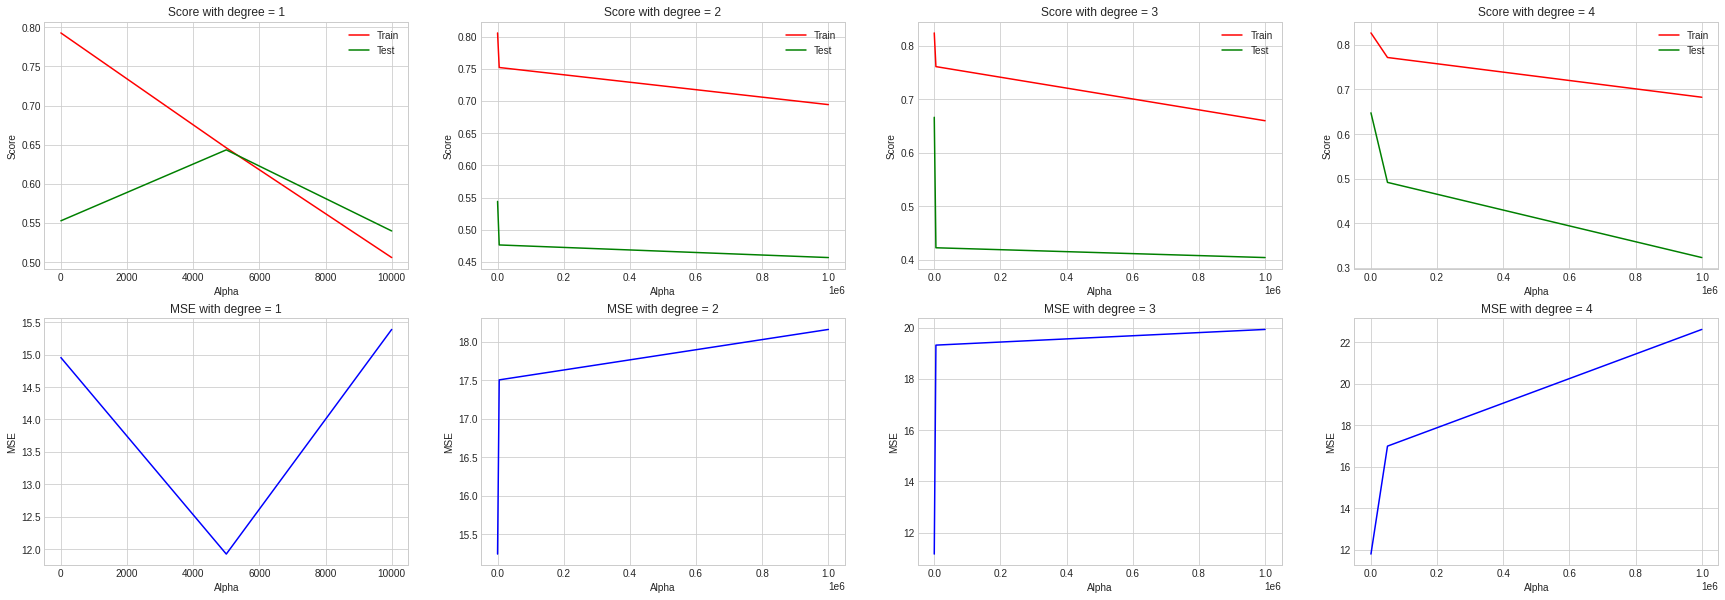

In [7]:
# Setup subplots
fig, axs = plt.subplots(2, 4, figsize=(30, 10))

# Show score (R^2) charts
alphas = []
r_sq_train = []
r_sq_test = []
for i, degree in enumerate(models, start=1):
    alphas.clear()
    r_sq_train.clear()
    r_sq_test.clear()

    for a in degree:
        alphas.append(a[0])
        r_sq_train.append(a[1])
        r_sq_test.append(a[2])

    plot = axs[0, (i - 1)]
    plot.set_title('Score with degree = {}'.format(i))
    plot.set(xlabel="Alpha", ylabel="Score")
    plot.plot(alphas, r_sq_train, c='red')
    plot.plot(alphas, r_sq_test, c='green')
    plot.legend(['Train', 'Test'])

# Show MSE charts
alphas = []
mses = []
for i, degree in enumerate(models, start=1):
    alphas.clear()
    mses.clear()

    for a in degree:
        alphas.append(a[0])
        mses.append(a[3])

    plot = axs[1, (i - 1)]
    plot.set_title('MSE with degree = {}'.format(i))
    plot.set(xlabel="Alpha", ylabel="MSE")
    plot.plot(alphas, mses, c='blue')

plt.show()